## Assumptions:

Aroon is a quite popular among technical analysts, it is supposed to detect trend reversals changes in asset prices.
I think that Aroon is too granular, espcially for low to mid float stocks with low market depth.
Detecting the convexity of the curved formed by successive prices (the line generated would be a polynomial fit) of low float stocks over an extended time period should give a better signal than Aroon.

In [2]:
import pandas as pd

import yfinance as yf
from talib import MA_Type
import talib
import numpy as np
from datetime import datetime, timedelta 
from time import gmtime, strftime
from csv import writer
import os
import sqlite3

from utils.db_manage import DBManager, QuRetType, dfToRDS, std_db_acc_obj
db_acc_obj = std_db_acc_obj() 


In [3]:
qu = f"SELECT * FROM NASDAQ_15 WHERE DATE > '2020-7-01'"
initialDF = db_acc_obj.exc_query(db_name='marketdata', query=qu, \
retres=QuRetType.ALLASPD)

In [4]:
initialDF

,Symbol,Date,Open,High,Low,Close,Volume
0,AACG,2020-07-02,1.30,1.3850,1.30,1.31,46700
1,AAL,2020-07-02,13.35,13.4200,12.42,12.50,86439500
2,AAME,2020-07-02,1.62,1.7300,1.58,1.70,19800
3,AAOI,2020-07-02,10.48,11.0302,10.39,10.79,881000
4,AAON,2020-07-02,53.47,54.2800,52.80,53.73,170300
...,...,...,...,...,...,...,...
576823,ZUMZ,2021-02-12,47.50,47.6199,46.34,46.87,141100
576824,ZVO,2021-02-12,6.09,7.3400,6.07,6.58,2292700
576825,ZWRKU,2021-02-12,10.74,10.9500,10.62,10.70,162200
576826,ZYNE,2021-02-12,5.55,6.4600,5.30,5.64,13786400


In [18]:
initialDF.to_csv('nasdaq_marketdata.csv')

dfTick = pd.read_csv('nasdaq_marketdata.csv')
dfTick = initialDF.loc[initialDF['Symbol']=='TSLA']
# IDXG : Convex

In [19]:
dfTick

,Symbol,Date,Open,High,Low,Close,Volume
3130,TSLA,2020-07-02,244.296,245.600,237.120,241.732,17250100
6581,TSLA,2020-07-03,241.732,241.732,241.732,241.732,0
10035,TSLA,2020-07-06,255.338,275.558,253.209,274.316,20569800
13490,TSLA,2020-07-07,278.200,285.900,267.342,277.972,21489600
16948,TSLA,2020-07-08,281.000,283.452,262.268,273.176,16311300
...,...,...,...,...,...,...,...
560198,TSLA,2021-02-08,869.670,877.770,854.750,863.420,20110900
564246,TSLA,2021-02-09,855.120,859.800,841.750,849.460,15121700
568308,TSLA,2021-02-10,843.640,844.820,800.020,804.820,36159700
572365,TSLA,2021-02-11,812.440,829.880,801.720,811.660,21608700


[0.00000e+00 1.00000e+00 2.00000e+00 ... 5.76441e+05 5.76442e+05
 5.76443e+05]


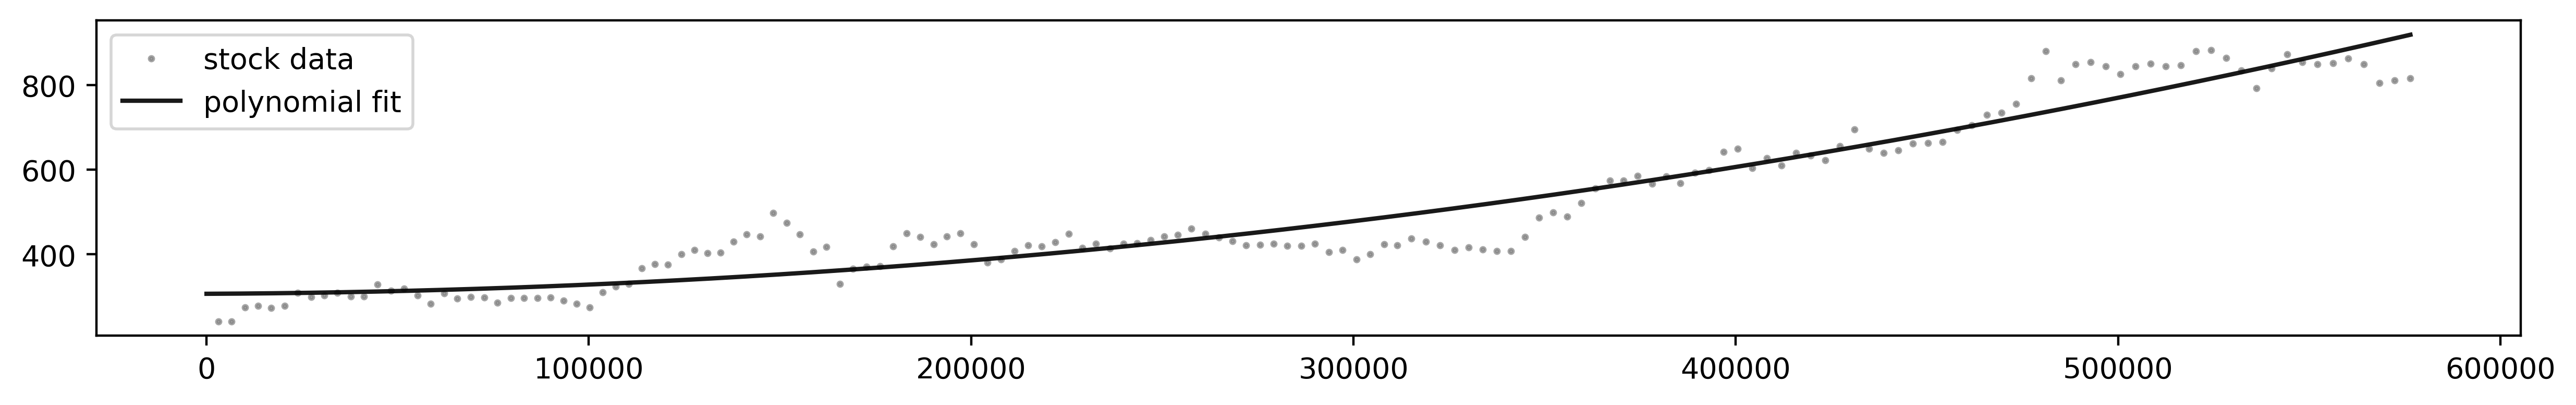

In [21]:
import matplotlib.pyplot as plt

# discretization of the dataset
x_data = dfTick.index.tolist()
y_data = dfTick.Close.tolist()


x = np.linspace(0, max(dfTick.index.tolist()), max(dfTick.index.tolist()) + 1)
print(x)
# polynomial fit of degree xx
pol = np.polyfit(x_data, y_data, 2)
y_pol = np.polyval(pol, x)


plt.figure(figsize=(15, 2), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(x_data, y_data, 'o', markersize=1.5, color='grey', alpha=0.7)
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()


# To do: assess the level of conexity on degree 2 or 3
# Set a threshold of convexity
# Assumption, the first point needs to be higher than the last one or start above the average price

In [ ]:
# https://en.wikipedia.org/wiki/Curve_fitting